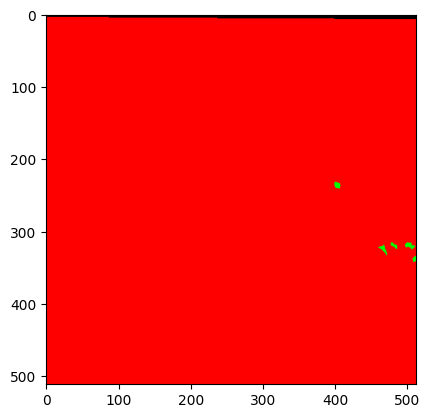

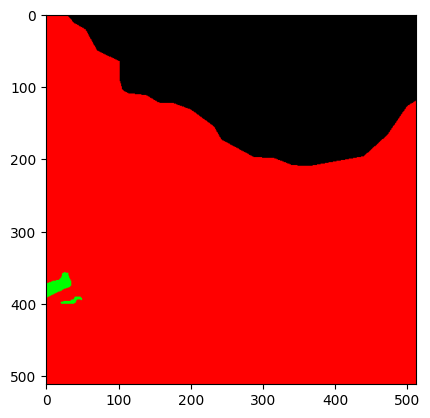

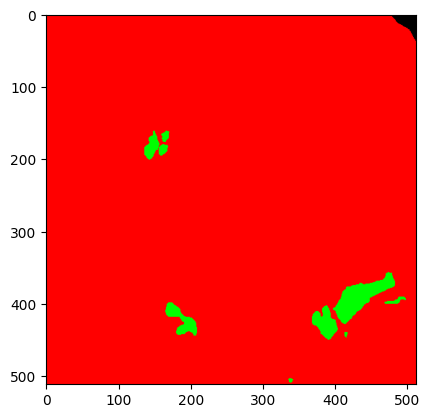

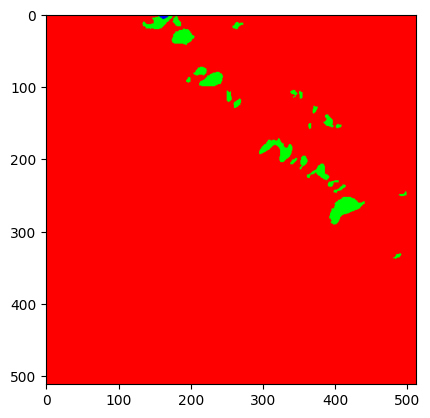

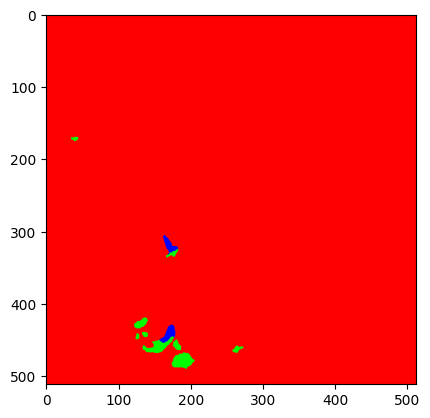

In [26]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

dirpath = Path("/data/jperez/datasets/HKH/processed_debug_nophys/train/")
# for fpath in dirpath.glob("tiff_*"):
#     im = np.load(fpath)
#     rgb = im[:, :, [2, 1, 0]]
#     rgb *= 255
#     rgb = rgb.astype(np.uint8)
#     print(rgb.dtype, rgb.shape, rgb.min(), rgb.max())

#     plt.figure()
#     plt.imshow(rgb)

# for fpath in dirpath.glob("mask_*"):
#     im = np.load(fpath)
#     print(im.dtype, im.shape, im.min(), im.max())

#     plt.figure()
#     plt.imshow(im)

from glacier_mapping.data.data import fetch_loaders, GlacierDataset

dataset = GlacierDataset(Path("/data/jperez/datasets/HKH/processed_debug_nophys/train"),
                         use_channels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         output_classes=[0, 1, 2],
                         physics_channel=None,
                         normalize="mean-std"
                         )

for i, (x, y) in enumerate(dataset):
    plt.figure()
    plt.imshow(y)

    if i > 20:
        break

In [1]:
import multiprocessing
import pathlib
from timeit import default_timer as timer

import rasterio
import rasterio.plot
import yaml
import torch
from addict import Dict
from tqdm import tqdm

from glacier_mapping.data.slice import get_mask, get_tiff_np, read_shp, read_tiff
from glacier_mapping.model.frame import Framework
from glacier_mapping.utils import istarmap

# TODO: Update code that gives FutureWarning and DeprecationWarning
import warnings

warnings.filterwarnings("ignore")



conf = Dict(yaml.safe_load(open("../conf/predict_slices.yaml")))

# % Prediction-specific config
runs_dir = pathlib.Path(conf.runs_dir)
run_name: str = conf.run_name
physics_scale = conf.physics_scale
physics_res = conf.physics_res
gpu_rank: int = conf.gpu_rank
window_size = conf.window_size
threshold = conf.threshold
tiff_dir = pathlib.Path(conf.tiff_dir)
dem_dir = pathlib.Path(conf.dem_dir)
labels_path = pathlib.Path(conf.labels_path)

output_dir = pathlib.Path(conf.output_dir) / conf.run_name / f"t={threshold}"
if not output_dir.exists():
    output_dir.mkdir(parents=True)

assert tiff_dir.exists()
assert labels_path.exists()
if not dem_dir.exists():
    print(
        f"dem_dir provided {dem_dir} does not exist, assuming this model does not use DEM"
    )

# % Load checkpoint using the training config
checkpoint_path = runs_dir / conf.run_name / "models" / "model_best.pt"
state = torch.load(checkpoint_path, map_location="cpu")
state["loader_opts"].processed_dir = "/data/jperez/datasets/HKH/processed_L07_2005_phys64_s1"
print(state["loader_opts"])

frame: Framework = Framework.from_checkpoint(
    checkpoint_path, device=gpu_rank, testing=True, override=state
)

# % Load data stuff
labels = read_shp(labels_path)

{'processed_dir': '/data/jperez/datasets/HKH/processed_L07_2005_phys64_s1', 'batch_size': 12, 'use_channels': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'output_classes': [0, 1, 2], 'normalize': 'mean-std', 'physics_channel': 10, 'class_names': ['BG', 'CleanIce', 'Debris']}
UNET dropout= 0.1


organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO


/data/jperez/datasets/debug/Landsat7_2005/image150.tif
uint8 uint8 (1859, 1556) (array([0, 1, 2], dtype=uint8), array([2886366,    5750,     488]))
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1556, 'height': 1859, 'count': 8, 'crs': CRS.from_epsg(32643), 'transform': Affine(30.0, 0.0, 418740.0,
       0.0, -30.0, 3762300.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


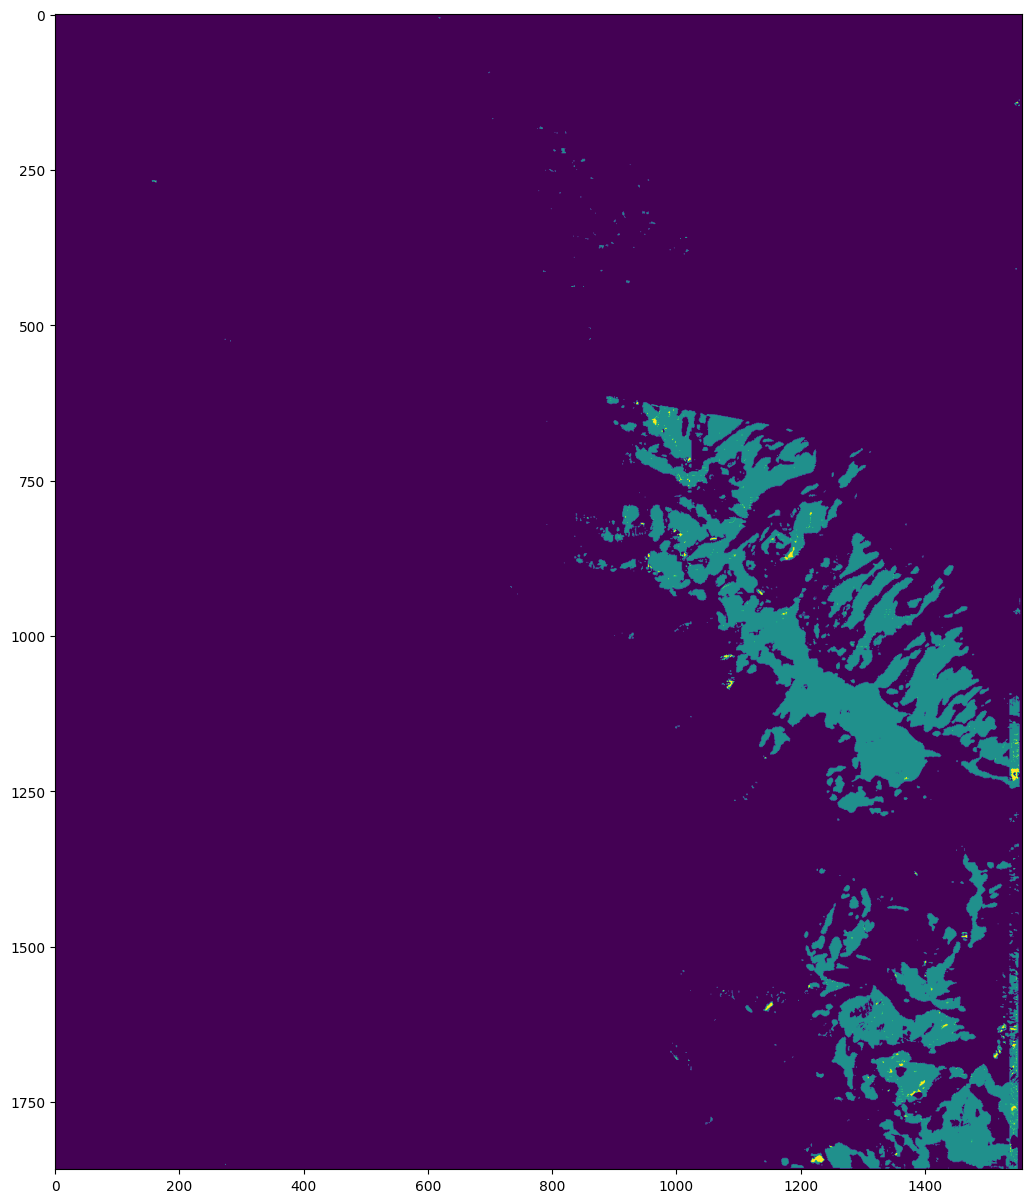

In [32]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

data = list(enumerate(Path("/data/jperez/datasets/debug/Landsat7_2005").glob("*.tif")))

for idx, fname in data:
    if "150" not in fname.stem:
        continue
    print(fname)
    tiff_fname = tiff_dir / fname
    dem_fname = dem_dir / fname

    # split_df = frame.df[frame.df["Landsat ID"] == fname.name]
    # if len(split_df) == 0:
    #     split = "ignored"
    # else:
    #     split = split_df.iloc[0]["split"]

    assert tiff_fname.exists()
    assert dem_fname.exists()

    label_mask = get_mask(tiff_fname, labels)
    x_arr = get_tiff_np(
        tiff_fname,
        dem_fname,
        physics_res=physics_res,
        physics_scale=physics_scale,
        verbose=(idx == 0),
    )
    y_pred, mask = frame.predict_whole(x_arr, window_size, threshold)
    y_true = frame.get_y_true(label_mask, None)

    print(y_pred.dtype, y_true.dtype, y_true.shape, np.unique(y_true, return_counts=True))

    plt.figure(figsize=(15, 15))
    plt.imshow(y_pred)

    from PIL import Image

    # Image.fromarray(y_true, "RGB").save(output_dir / f"{tiff_fname.stem}_true.png")

    with rasterio.Env():
        # Open TIFF file with rasterio
        src = read_tiff(tiff_fname)

        profile = src.profile
        print(profile)
        profile["dtype"] = str(y_pred.dtype)
        profile["height"] = y_pred.shape[0]
        profile["width"] = y_pred.shape[1]
        profile["blockxsize"] = 2048
        profile["blockysize"] = 2048
        profile["count"] = 2

        with rasterio.open(
            output_dir / f"{tiff_fname.stem}.tif", "w", **profile
        ) as dst:
            dst.write(y_pred, 1)
            dst.write(y_true, 2)

uint8 (512, 512) 0 2


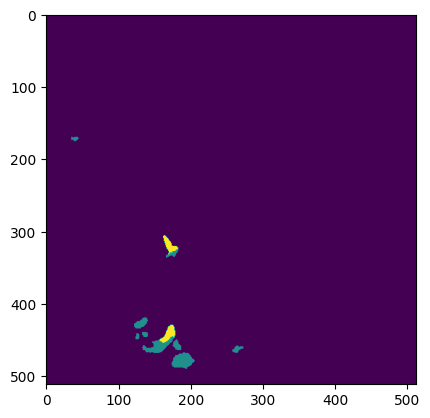

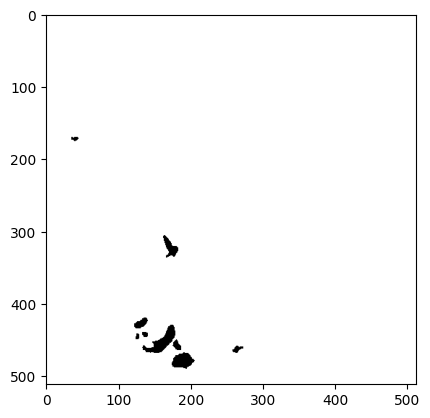

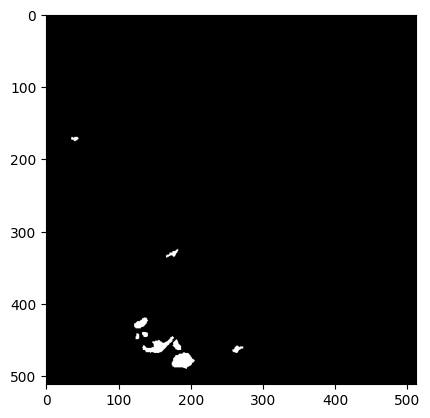

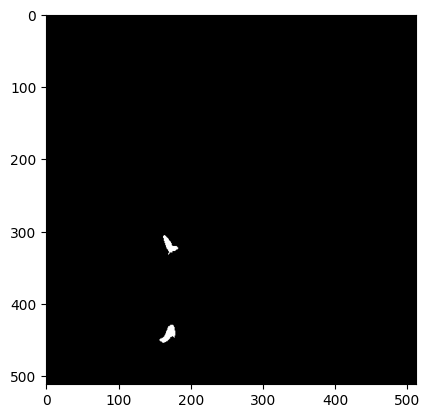

In [9]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

data = list(enumerate(Path("/data/jperez/datasets/HKH/processed_debug_nophys/train").glob("mask_*")))

for i, fpath in data:
    if i != 1:
        continue
    im = np.load(fpath)
    print(im.dtype, im.shape, im.min(), im.max())

    plt.figure()
    plt.imshow(im)

    plt.figure()
    lbl0 = np.zeros_like(im)
    lbl0[im==0] = 1
    plt.imshow(lbl0, cmap='gray')

    plt.figure()
    lbl1 = np.zeros_like(im)
    lbl1[im==1] = 1
    plt.imshow(lbl1, cmap='gray')

    plt.figure()
    lbl2 = np.zeros_like(im)
    lbl2[im==2] = 1
    plt.imshow(lbl2, cmap='gray')
